In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4562950%2F8813963%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240703%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240703T223020Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dba6230935fb8be22c114639d272b2e60ca5627fe9a99101fbc8337c94d69c6125e6f2ed22326dc6203ae800ae723fa3d7c3a90c7b4ac4e7903699db05a06ae2e8fa2966858780af17c029606baa8366c00619d1c42a362bbbca17cded78414fc1326e03b360e10345161a40810109aa12e810c1f8987a1adcfed5af9d503832d02b2a63099f328ca3a9077528bfc83f625b811e477008ef47e3e41f3c1a534026d37cf06a1ed1996adda7740f13fbe1df726fddde5424ce4356f5ab57cc3bac4a0fbed6fa2f3ab79ca996e50a799d645d302b21ab96a4b6f3ace292f9b0b7867fa6b6a5d3af9a958dbe04609bd8c3ca112d1398d0593da8121e0076f9b56586c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16081895452 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


<a name='1'></a>
## 1 - Packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, Rescaling, RandomZoom, Resizing, RandomBrightness, RandomContrast

<a name='1-1'></a>
### 1.1 Create the Dataset and Split it into Training and Validation Sets

In [4]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory("/kaggle/input/Plant Disease-4-classes/Plant Disease-5/Train/Train",
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory("/kaggle/input/Plant Disease-4-classes/Plant Disease-5/Validation/Validation",
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory("/kaggle/input/Plant Disease-4-classes/Plant Disease-5/Test/Test",
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 4400 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Found 320 files belonging to 4 classes.


Now let's take a look at some of the images from the training set:

In [5]:
class_names = train_dataset.class_names

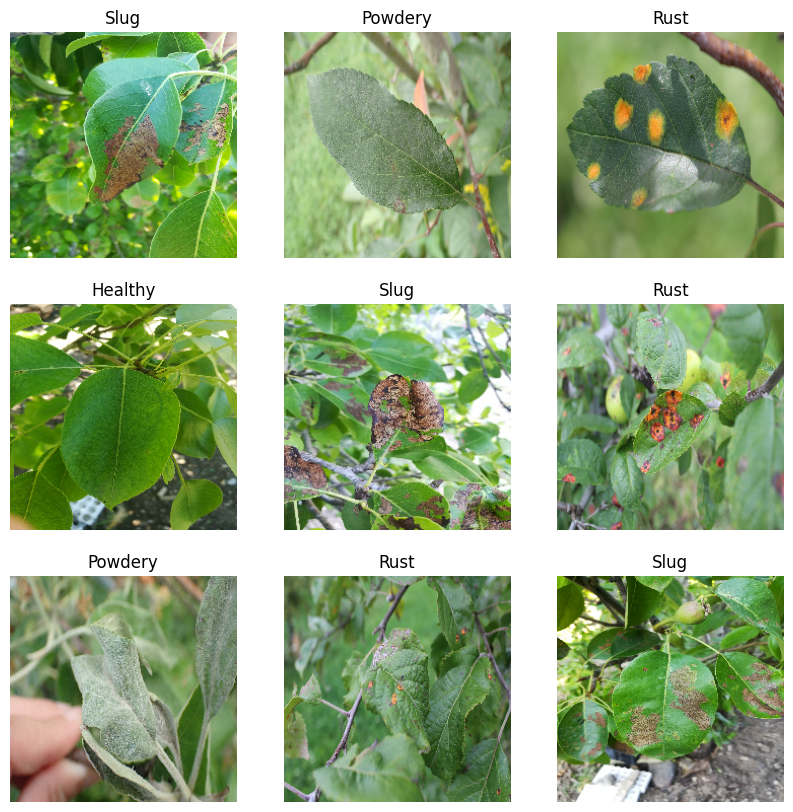

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='ex-1'></a>
### data_augmenter

Implement a function for data augmentation. Use a `Sequential` keras model composed of multiple layers

In [7]:
# data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of multiple layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal", seed=42)),
    data_augmentation.add(RandomRotation(0.1, seed=42, fill_mode="nearest")),
    data_augmentation.add(RandomBrightness(0.1, seed=42)),
    data_augmentation.add(RandomContrast(0.1, seed=42)),
    data_augmentation.add(RandomZoom(0.2, fill_mode="nearest", seed=42)),

    return data_augmentation

Take a look at how an image from the training set has been augmented with simple transformations:

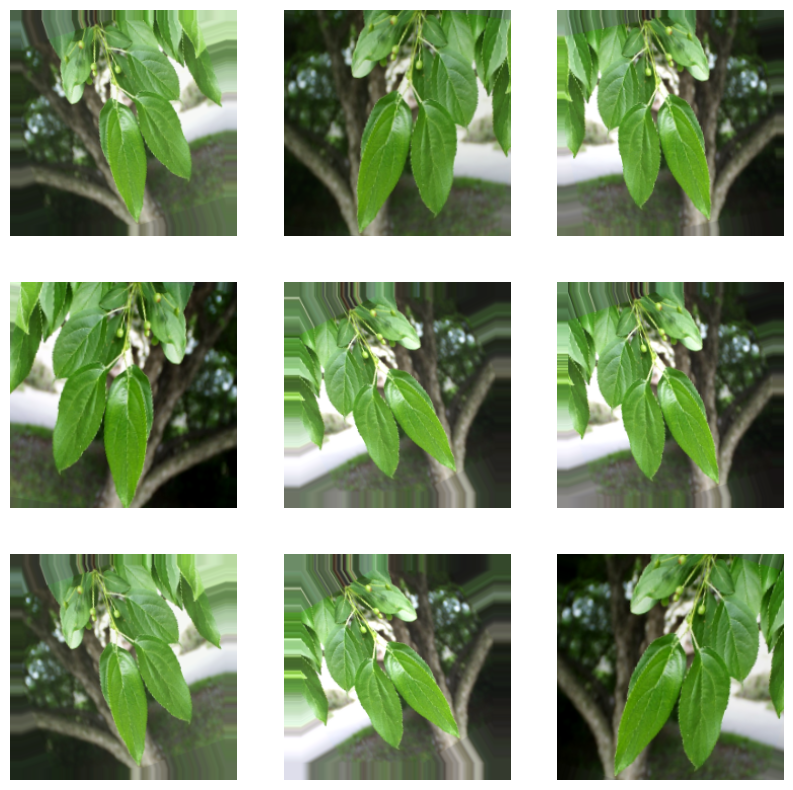

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255) # commented as if we use a rescailing layer in the data_augmenter
        plt.axis('off')

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v3.preprocess_input.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)

Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images.

In [11]:
# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [12]:
# # Shows the different label probabilities in one tensor
# label_batch

Now decode the predictions made by the model. Earlier, when you printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

<a name='ex-2'></a>
### plant_model

In [13]:
# Model

num_classes = len(class_names)

def plant_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for multiclass classification out of the MobileNetV3Large model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV3Large(input_shape=input_shape,
                                                        include_top= False, # <== Important!!!!
                                                        weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv3Large input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmenter()(inputs)

    # data preprocessing using the same weights the model was trained on
#     x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)

    x = tfl.Dense(256, activation = 'relu')(x)
    x = tfl.Dropout(0.3)(x)

    x = tfl.Dense(128, activation = 'relu')(x)

    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)

    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(num_classes, activation = 'softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

Create your new model using the data_augmentation function defined earlier.

In [14]:
model2 = plant_model(IMG_SIZE, data_augmenter())

12683000/12683000 [==============================] - 0s 0us/step


The base learning rate has been set for you, so you can go ahead and compile the new model and run it for 5 epochs:

In [38]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=3,
                                                 verbose=1,
                                                 min_lr=1e-5)

check_point = tf.keras.callbacks.ModelCheckpoint(
                        filepath="model_with_data_augmentation.keras",
                        save_best_only=True,
                        monitor="val_loss")

In [40]:
initial_epochs = 10 # best from the graph is 6
history = model2.fit(train_dataset,
                     validation_data=validation_dataset,
                     epochs=initial_epochs,
                     callbacks=[reduce_lr, check_point])

Epoch 1/10
69/69 [==============================] - 232s 3s/step - loss: 0.8608 - accuracy: 0.7730 - val_loss: 0.5953 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - 205s 3s/step - loss: 0.1642 - accuracy: 0.9441 - val_loss: 0.2081 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - 206s 3s/step - loss: 0.0973 - accuracy: 0.9677 - val_loss: 0.1209 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 4/10
69/69 [==============================] - 204s 3s/step - loss: 0.0771 - accuracy: 0.9755 - val_loss: 0.1171 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 5/10
69/69 [==============================] - 205s 3s/step - loss: 0.0596 - accuracy: 0.9807 - val_loss: 0.1025 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 6/10
69/69 [==============================] - 202s 3s/step - loss: 0.0422 - accuracy: 0.9852 - val_loss: 0.7175 - val_accuracy: 0.8425 - lr: 0.0010
Epoch 7/10
69/69 [==============================] - 203s 3s/step - loss: 0.1

Plot the training and validation accuracy:

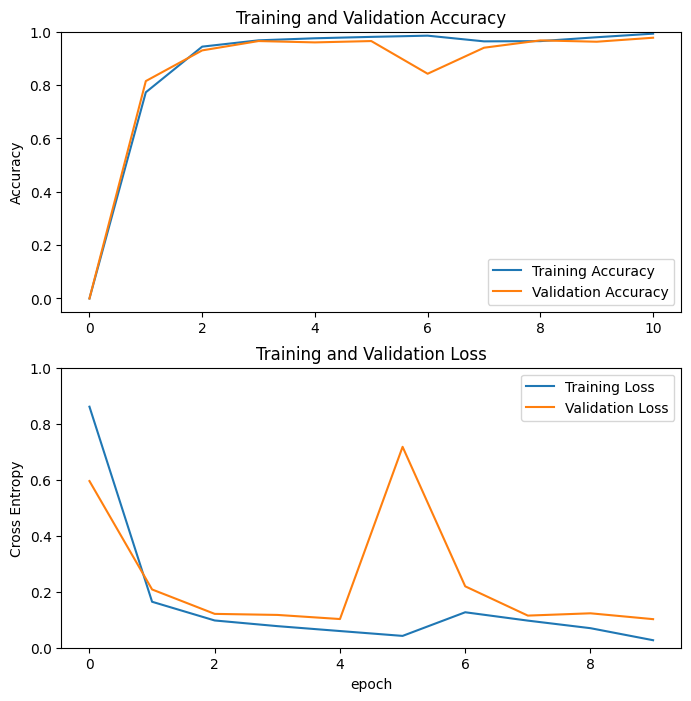

In [41]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
class_names

['Healthy', 'Powdery', 'Rust', 'Slug']

The results are ok, but could be better. Next, try some fine-tuning.

<a name='3-3'></a>
### 3.3 - Fine-tuning the Model

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth.

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

In [43]:
# base_model

<a name='ex-3'></a>
### Fine-Tuning

In [44]:
# Fine-tuning

base_model = model2.layers[2]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 35

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01 * base_learning_rate),
              metrics=['accuracy'])

Number of layers in the base model:  263


In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-8)

check_point = tf.keras.callbacks.ModelCheckpoint(
                        filepath="model_with_fine_tuning.keras",
                        save_best_only=True,
                        monitor="val_loss")

In [46]:
fine_tune_epochs = 20 # best from graph is 13
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                        callbacks=[early_stopping, reduce_lr, check_point])

Epoch 10/30
69/69 [==============================] - 225s 3s/step - loss: 0.0180 - accuracy: 0.9945 - val_loss: 0.0985 - val_accuracy: 0.9775 - lr: 1.0000e-05
Epoch 11/30
69/69 [==============================] - 197s 3s/step - loss: 0.0177 - accuracy: 0.9966 - val_loss: 0.1021 - val_accuracy: 0.9750 - lr: 1.0000e-05
Epoch 12/30
69/69 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9945
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
69/69 [==============================] - 206s 3s/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.1028 - val_accuracy: 0.9750 - lr: 1.0000e-05
Epoch 13/30
69/69 [==============================] - 211s 3s/step - loss: 0.0158 - accuracy: 0.9943 - val_loss: 0.1060 - val_accuracy: 0.9775 - lr: 2.0000e-06


Ahhh, quite an improvement! A little fine-tuning can really go a long way.

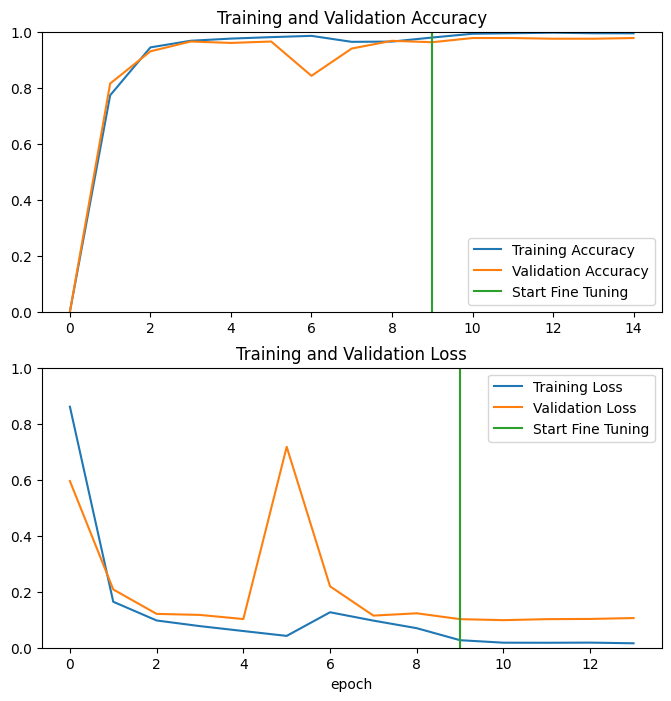

In [47]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluating the model

In [48]:
loss, accuracy = model2.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)
print("Validation Loss :", loss)

7/7 [==============================] - 14s 76ms/step - loss: 0.1060 - accuracy: 0.9775
Validation accuracy : 0.9775000214576721
Validation Loss : 0.10595259070396423


In [49]:
loss, accuracy = model2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print("Test Loss :", loss)

5/5 [==============================] - 11s 92ms/step - loss: 0.1606 - accuracy: 0.9750
Test accuracy : 0.9750000238418579
Test Loss : 0.16059130430221558


# Prediction a batch of images of the test dataset (32 image)

1/1 [==============================] - 0s 28ms/step


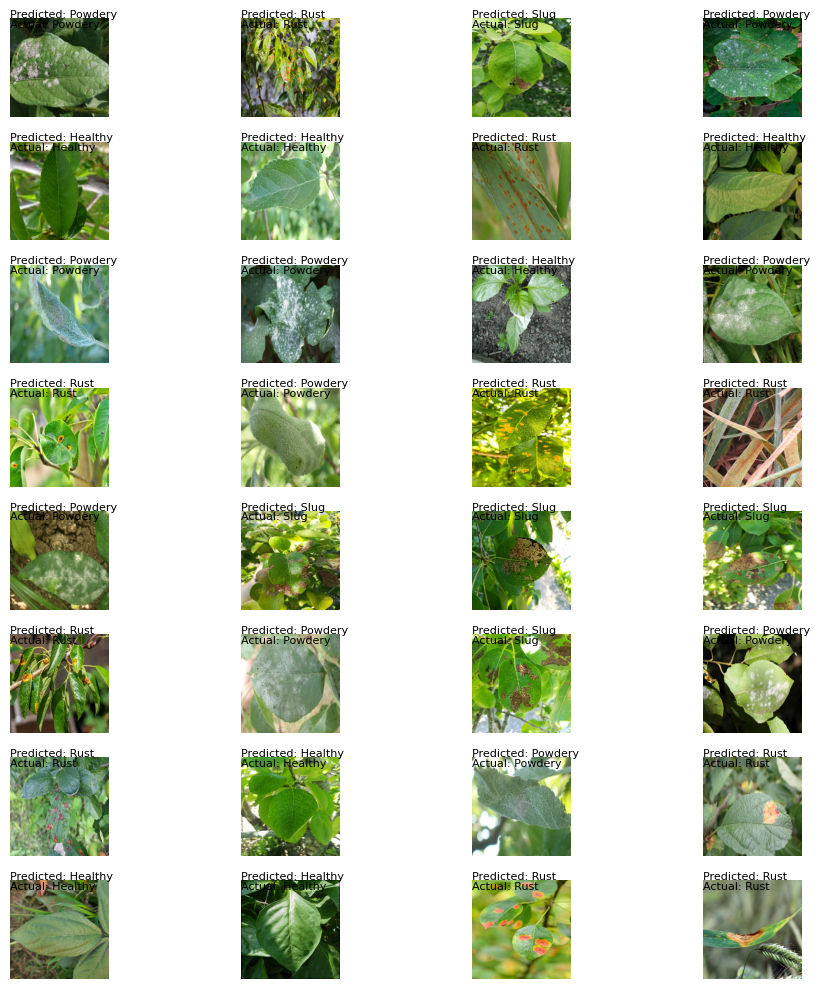

In [50]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model2.predict_on_batch(image_batch).flatten()

predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]

y_actual_index = []
y_pred_index = []

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_class_name = class_names[labels[i]]
        y_actual_index.append(labels[i])
        current_image = np.expand_dims(images[i], axis=0)
        current_prediction = model2.predict(current_image)
        current_predicted_class_index = np.argmax(current_prediction[0])
        y_pred_index.append(current_predicted_class_index)
        current_predicted_class_name = class_names[current_predicted_class_index]

        # Use plt.text for subtitles (adjust positions as needed)
        plt.text(0.05, 0.85, f"Actual: {actual_class_name}", ha='left', va='top', fontsize=8)
        plt.text(0.05, 0.95, f"Predicted: {current_predicted_class_name}", ha='left', va='bottom', fontsize=8)

        plt.axis("off")
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [51]:
test_dataset1 = image_dataset_from_directory("/kaggle/input/Plant Disease-4-classes/Plant Disease-5/Test/Test",
                                             batch_size=400,
                                             image_size=IMG_SIZE)

Found 320 files belonging to 4 classes.


# Prediction the whole test dataset

In [52]:
# Retrieve a batch of images from the test set
'''image_batch1, label_batch1 = test_dataset1.as_numpy_iterator().next()
predictions1 = model2.predict_on_batch(image_batch1).flatten()

predicted_class_index1 = np.argmax(predictions1[0])
predicted_class_name1 = class_names[predicted_class_index1]

predicted_labels = []

plt.figure(figsize=(30, 20))
for images1, labels1 in test_dataset1.take(1):
    for i in range(320):
        ax = plt.subplot(20, 20, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_class_name1 = class_names[labels1[i]]
        current_image1 = np.expand_dims(images1[i], axis=0)
        current_prediction1 = model2.predict(current_image1)
        current_predicted_class_index1 = np.argmax(current_prediction1[0])
        predicted_labels.append(current_predicted_class_index1)
        current_predicted_class_name1 = class_names[current_predicted_class_index1]

        # Use plt.text for subtitles (adjust positions as needed)
        plt.text(0.05, 0.85, f"Actual: {actual_class_name1}", ha='left', va='top', fontsize=8)
        plt.text(0.05, 0.95, f"Predicted: {current_predicted_class_name1}", ha='left', va='bottom', fontsize=8)

        plt.axis("off")
plt.tight_layout()  # Adjust spacing between subplots
plt.show()'''

'image_batch1, label_batch1 = test_dataset1.as_numpy_iterator().next()\npredictions1 = model2.predict_on_batch(image_batch1).flatten()\n\npredicted_class_index1 = np.argmax(predictions1[0])\npredicted_class_name1 = class_names[predicted_class_index1]\n\npredicted_labels = []\n\nplt.figure(figsize=(30, 20))\nfor images1, labels1 in test_dataset1.take(1):\n    for i in range(320):\n        ax = plt.subplot(20, 20, i + 1)\n        plt.imshow(images[i].numpy().astype("uint8"))\n        actual_class_name1 = class_names[labels1[i]]\n        current_image1 = np.expand_dims(images1[i], axis=0)\n        current_prediction1 = model2.predict(current_image1)\n        current_predicted_class_index1 = np.argmax(current_prediction1[0])\n        predicted_labels.append(current_predicted_class_index1)\n        current_predicted_class_name1 = class_names[current_predicted_class_index1]\n\n        # Use plt.text for subtitles (adjust positions as needed)\n        plt.text(0.05, 0.85, f"Actual: {actual_cl

In [53]:

# Retrieve a batch of images from the test set
image_batch1, label_batch1 = test_dataset1.as_numpy_iterator().next()
predictions1 = model2.predict_on_batch(image_batch1).flatten()

predicted_class_index1 = np.argmax(predictions1[0])
predicted_class_name1 = class_names[predicted_class_index1]

predicted_labels = []

for images1, labels1 in test_dataset1.take(1):
    for i in range(112):
        actual_class_name1 = class_names[labels1[i]]
        current_image1 = np.expand_dims(images1[i], axis=0)
        current_prediction1 = model2.predict(current_image1)
        current_predicted_class_index1 = np.argmax(current_prediction1[0])
        predicted_labels.append(current_predicted_class_index1)
        current_predicted_class_name1 = class_names[current_predicted_class_index1]

1/1 [==============================] - 0s 22ms/step


# Confusion Matrix

10/10 [==============================] - 0s 46ms/step


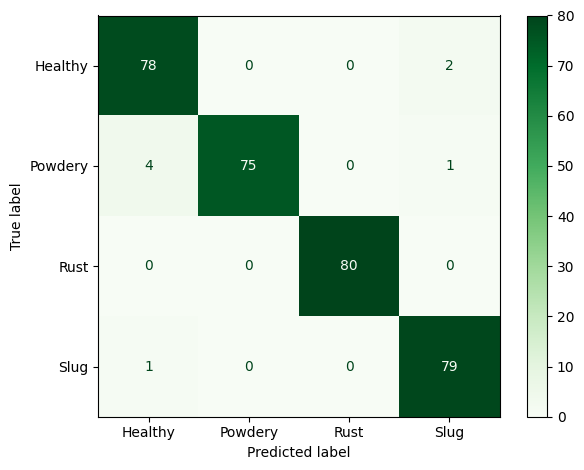

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the entire test dataset
predicted_labels = []
true_labels = []

for images, labels in test_dataset1:
    predictions = model2.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels)

# Convert true labels to numpy array
true_labels = np.array(true_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp_cm = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp_cm.plot(cmap="Greens")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Classification Report

In [55]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

     Healthy       0.94      0.97      0.96        80
     Powdery       1.00      0.94      0.97        80
        Rust       1.00      1.00      1.00        80
        Slug       0.96      0.99      0.98        80

    accuracy                           0.97       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.97      0.98       320



1. **TP (True Positive)** is a number of right predictions that are correct
when label is True and predicted as True

2. **TN (True Negative)** is a number of right predictions that are incorrect
when label is False and predicted as False

3. **FP (False Positive)** is a number of not right predictions that are incorrect
when label is False but predicted as True

4. **FN (False Negative)** is a number of not right predictions that are correct
when label is True but predicted as False

5. **Precision** is an accuracy of positive predictions
Precision represents percent of correct predictions
In other words, it is ability not to label an image as positive that is actually negative
Precision is calculated by following equation:
Precision = TP / (TP + FP)

6. **Recall** is a fraction of positive predictions among all True samples
In other words, it is ability to find all positive samples
Recall is calculated by following equation:
Recall = TP / (TP + FN)

7. **F1-score** is a so called weighted harmonic mean of the Precision and Recall
F1-score also known as balanced F-score or F-measure,
as it incorporates Precision and Recall into computation,
and, therefore, contributions of Precision and Recall to F1-score are equal
F1-score reaches its best value at 1 and worst score at 0
F1-score is calculated by following equation:
F1-score = 2 (Recall Precision) / (Recall + Precision)

8. **Support** is a number of occurrences of each class in a dataset

9. **Accuracy** is a global accuracy of entire classifier
Accuracy is calculated by following equation:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
(all correct / all)

10. **macro avg** calculates the mean of the metrics,
giving equal weight to each class

11. **weighted avg** calculates the weighted mean of the metrics
It takes into account imbalance of samples' number for every class
It weights every metric by occurrences of each class in a dataset

In [56]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [57]:
model = model2

# Convert the TensorFlow model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('plant_model_4classes_v3_32.tflite', 'wb') as f:
    f.write(tflite_model)

In [58]:
model.save("plant_model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
!wget https://extension.usu.edu/pests/images/factsheets/plantdiseases/powdery-mildew-winter-squash.jpg

--2024-07-05 01:08:13--  https://extension.usu.edu/pests/images/factsheets/plantdiseases/powdery-mildew-winter-squash.jpg
Resolving extension.usu.edu (extension.usu.edu)... 129.123.54.40
Connecting to extension.usu.edu (extension.usu.edu)|129.123.54.40|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://extension.usu.edu/planthealth/images/factsheets/plantdiseases/powdery-mildew-winter-squash.jpg [following]
--2024-07-05 01:08:13--  https://extension.usu.edu/planthealth/images/factsheets/plantdiseases/powdery-mildew-winter-squash.jpg
Reusing existing connection to extension.usu.edu:443.
HTTP request sent, awaiting response... 200 OK
Length: 249289 (243K) [image/jpeg]
Saving to: ‘powdery-mildew-winter-squash.jpg.1’

powdery-mildew-wint 100%[===================>] 243.45K  --.-KB/s    in 0.06s   

2024-07-05 01:08:14 (4.31 MB/s) - ‘powdery-mildew-winter-squash.jpg.1’ saved [249289/249289]



1/1 [==============================] - 0s 25ms/step


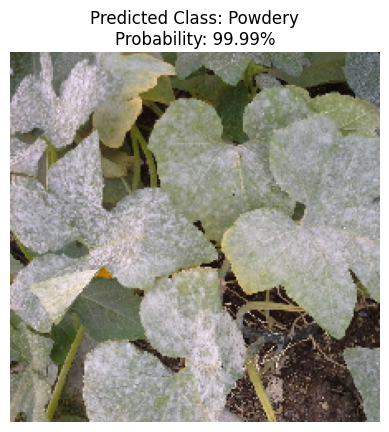

In [60]:
# Load the image
image = tf.keras.preprocessing.image.load_img("powdery-mildew-winter-squash.jpg", target_size=(224,224))

# Preprocess the image
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# Predict the image
predictions = model2.predict(image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Get the predicted class name
predicted_class_name = class_names[predicted_class]

# Get the probability of the predicted class
probability = predictions[0][predicted_class] * 100

# Plot the image
plt.imshow(image[0]/255)
plt.axis("off")

# Print the predicted class and probability
plt.title(f"Predicted Class: {predicted_class_name}\nProbability: {probability:.2f}%")

# Show the plot
plt.show()